<a href="https://colab.research.google.com/github/ngupta23/inventory-deterministic/blob/main/Inventory%20Management%20-%20Deterministic%20(Class%20Version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Article Link
https://towardsdatascience.com/inventory-management-for-retail-deterministic-demand-311682c02518

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings

In [2]:
warnings.filterwarnings('ignore')

## Parameters

### Functions

In [3]:
# Deterministic constant demand
def demand(D):
    return D

In [4]:
# Order every cycle time
def order(t, T, Q):
    """
    t = current time period
    T = Replenishment Period
    Q = Order Quantity 1: 0 stock  
    """
    # Reorder when t = 1 + k x T 
    if ((t-1) % T)==0 or (t==1): #((t-1) % T)==0
        result = Q
    else:
        result = 0
    return result

In [5]:
# Simulation version 1: with leadtime uncompensated
def sim(Q, T, D_day, T_total, LD):
    """
    Q = Order Quantity 1: 0 stock
    T = Replenishment Period
    D_day = Demand per day (unit/day)
    T_total = Total Time (days)
    LD = Lead Time between ordering and receiving (i.e. Cycle Time)
    """
    df_sim = pd.DataFrame({'time': np.array(range(1, T_total+1))})
    
    # Demand Function ("demand" = demand per day)
    df_sim['demand'] = df_sim['time'].apply(lambda t: demand(D_day))
    
    # Order Function ("order" = how many units to order each day?)
    df_sim['order'] = df_sim['time'].apply(lambda t: order(t, T, Q))
    
    # Inventory on Hand = Order - Demand
    df_sim['ioh'] = df_sim['order'].cumsum().shift(LD) - df_sim['demand'].cumsum()

    # Inventory on Hand: Add extra records for the replenishment time at t = k x T - LD (for visualisation)
    df_simp = df_sim[df_sim['time'].apply(lambda t: ((t-LD) % T)==0 and (t!=0 + LD))]
    df_simp['ioh'] = df_simp['ioh'] + Q
    df_sim = pd.concat([df_sim, df_simp]).sort_values(['time', 'ioh'], ascending= [True, True])
    
    # Print Results
    print("Demand during cycle time: {:,} units".format(round(D_day * T, 2)))
    print("Average IOH for {:,} days cycle time: {:,} units".format(T, round(df_sim['ioh'].mean(),2)))
    
    return df_sim

---

## Initial Rule
#### Parameters

In [ ]:
# Total Demand (units/year)
D = 2000
# Total Time (days)
T_total = 365
# Demand per day (unit/day)
D_day = D/T_total
# Cost of product ($/unit)
c = 50
# Cost of placing an order ($/order)
c_t = 500

# Holding Cost (% unit cost per year)
h = .25
c_e = h * c
# Selling Price ($/unit)
p = 75
# Lead Time between ordering and receiving
LD = 0

# Order Quantity 1: 0 stock
Q = 55

# Cost of shortage ($/unit)
c_s = 12

# Replenishment Period
T = get_replenishment_period(Q=Q, D_day=D_day)

# Number of orders per year
num_orders = get_number_of_orders(D=D, Q=Q)


In [16]:
class DeterministicDemandSimulator():
  def __init__(self, total_demand, total_time, cost_of_placing_order, replenishment_quantity, unit_cost, holding_cost_per_unit, manufacturing_cycle_time):
    """
    """
    self.total_demand = total_demand
    self.total_time = total_time
    self.replenishment_quantity = replenishment_quantity
    self.unit_cost = unit_cost
    self.cost_of_placing_order = cost_of_placing_order
    self.holding_cost_per_unit = holding_cost_per_unit
    self.manufacturing_cycle_time = manufacturing_cycle_time
    
  def _set_demand_per_day(self):
    self.demand_per_day = np.ceil(self.total_demand/self.total_time)

  def _set_replenishment_period(self):
    """Set the time between orders
    """
    self.replenishment_period = math.floor(self.replenishment_quantity/self.demand_per_day)

  def _set_number_of_orders(self):
    """Set the number of prelenishment orders placed in the "total_time" days
    """
    self.num_orders = math.ceil(self.total_demand/self.replenishment_quantity)

  def setup(self):
    """
    """
    self._set_demand_per_day()
    self._set_replenishment_period()
    self._set_number_of_orders()

  def get_demand_per_day(self):
    """Return Deterministic constant demand
    """
    return self.demand_per_day

  def get_order_quantity_per_day(self, present_day):
      """
      Order every cycle time
      t = current time period
      """
      # Reorder when t = 1 + k x T 
      if ((present_day-1) % self.replenishment_period)==0 or (present_day==1): 
          return self.replenishment_quantity
      else:
          return 0

  # Simulation version 1: with leadtime uncompensated
  def sim(self):
      """
      Q = Order Quantity 1: 0 stock
      T = Replenishment Period
      D_day = Demand per day (unit/day)
      T_total = Total Time (days)
      LD = Lead Time between ordering and receiving (i.e. Cycle Time)
      """
      df_sim = pd.DataFrame({'time': np.array(range(1, self.total_time+1))})
      
      # Demand Function ("demand" = demand per day)
      df_sim['demand'] = df_sim['time'].apply(lambda t: self.get_demand_per_day())
      
      # Order Function ("order" = how many units to order each day?)
      df_sim['order'] = df_sim['time'].apply(lambda t: self.get_order_quantity_per_day(t))
      
      # Inventory on Hand = Order - Demand
      df_sim['ioh'] = df_sim['order'].cumsum().shift(self.manufacturing_cycle_time) - df_sim['demand'].cumsum()

      # Inventory on Hand: Add extra records for the replenishment time at t = k x T - LD (for visualisation)
      df_simp = df_sim[df_sim['time'].apply(lambda t: ((t-self.manufacturing_cycle_time) % self.replenishment_period)==0 and (t!=0 + self.manufacturing_cycle_time))]
      df_simp['ioh'] = df_simp['ioh'] + self.replenishment_quantity
      df_sim = pd.concat([df_sim, df_simp]).sort_values(['time', 'ioh'], ascending= [True, True])
      
      # Print Results
      demand_during_cycle_time = math.ceil(self.demand_per_day * self.replenishment_period)
      print(f"Demand during cycle time: {demand_during_cycle_time} units")

      avg_ioh = round(df_sim['ioh'].mean(),2)
      print(f"Average IOH for Replenishment Period = {self.replenishment_period} days is {avg_ioh} units")
      
      return df_sim
      
  def _set_order_cost(self):
    """
    """
    order_cost = (self.unit_cost * self.total_demand) + (self.cost_of_placing_order * self.num_orders)

  def _set_holding_cost(self):
    """
    """
    self.holding_cost = self.holding_cost_per_unit * (self.replenishment_quantity / 2)

  def _set_relevant_cost(self):
    """
    """
    self.relevant_cost = self.order_cost + self.holding_cost    

In [17]:
dds = DeterministicDemandSimulator(
  total_demand = 2000,
  total_time = 365,
  replenishment_quantity = 55,
  unit_cost = 50,
  cost_of_placing_order = 500,
  holding_cost_per_unit = 12.5,
  manufacturing_cycle_time = 0
)

In [18]:
dds.setup()

In [19]:
dds.demand_per_day, dds.replenishment_period, dds.num_orders

(6.0, 9, 37)

In [21]:
df_sim1

,time,demand,order,ioh
0,1,6.0,55,49.0
1,2,6.0,0,43.0
2,3,6.0,0,37.0
3,4,6.0,0,31.0
4,5,6.0,0,25.0
...,...,...,...,...
360,361,6.0,55,89.0
361,362,6.0,0,83.0
362,363,6.0,0,77.0
363,364,6.0,0,71.0


In [20]:
df_sim1 = dds.sim()

Demand during cycle time: 54 units
Average IOH for Replenishment Period = 9 days is 47.96 units


### Cost Visualization


In [ ]:
#### Yearly Cost Components
order_cost = c*D + c_t * num_orders
holding_cost = c_e * Q/2
# shortage_cost = c_s * E
relevant_cost = order_cost + holding_cost

#### Simulation

In [ ]:
print("LD = {:,} days".format(LD))
df_sim1 = sim(Q, T, D_day, T_total, LD)

LD = 0 days
Demand during cycle time: 54.79 units
Average IOH for 10 days cycle time: 31.4 units


#### Plot

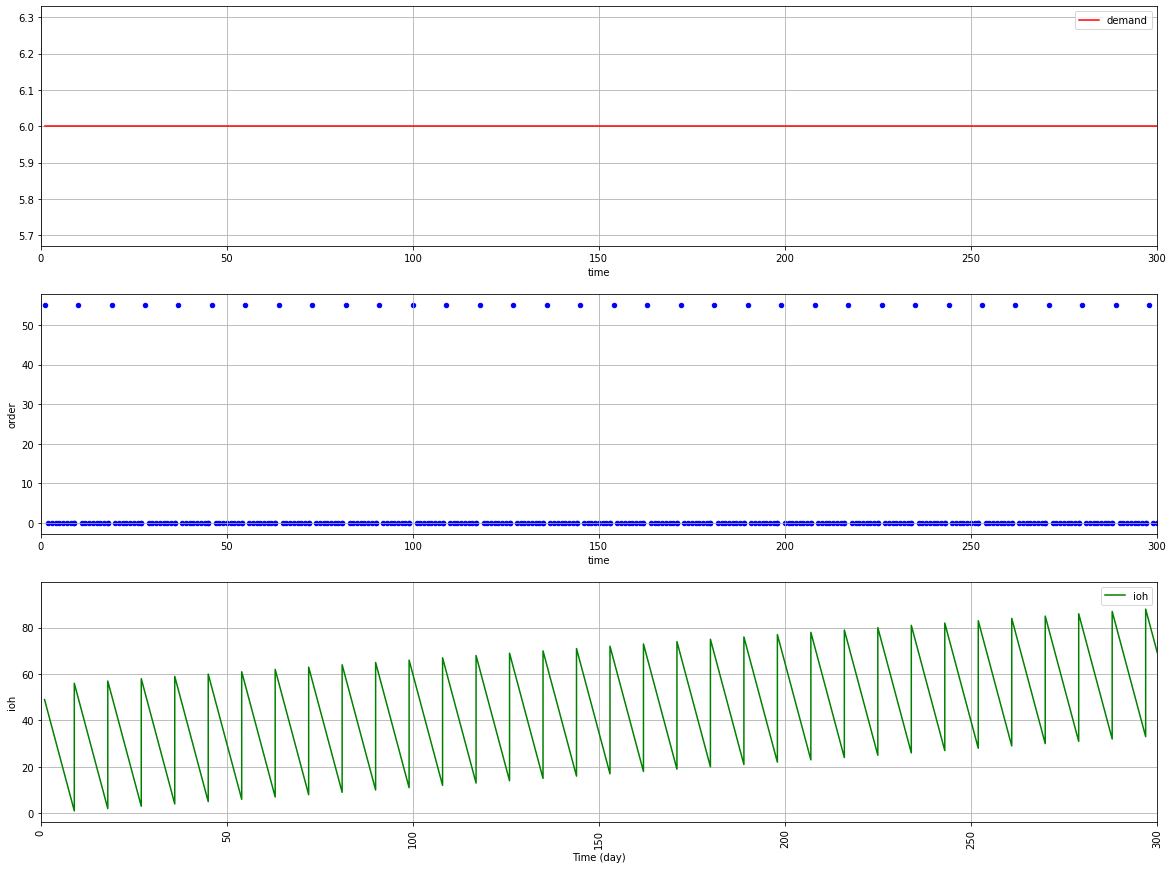

In [22]:
# Plot
figure, axes = plt.subplots(3, 1)

df_sim1.plot(figsize=(20, 12), xlim=[0,300] , x='time', y='demand', ax=axes[0], grid = True, color = 'r')
df_sim1.plot.scatter(figsize=(20, 12), xlim=[0,300], x='time', y='order', ax=axes[1], grid = True, color ='b')
df_sim1.plot(figsize=(20, 15), xlim=[0, 300], x='time', y='ioh', ax=axes[2], grid = True, color = 'g')

plt.xlabel('Time (day)')
plt.ylabel('ioh')
plt.xticks(rotation=90)

plt.show()